<a href="https://colab.research.google.com/github/KrupaMistry18/Amazon-Polarity-Imbalance/blob/main/llm_classicalrecommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

        candidate_series     score
0         Schitt's Creek  0.796552
1              Ted Lasso  0.796552
2              Panchayat  0.796552
3      Never Have I Ever  0.787097
4      Kim's Convenience  0.718304
5          Modern Family  0.718304
6   Parks and Recreation  0.709544
7         Emily in Paris  0.705518
8          Gilmore Girls  0.665745
9         The Good Place  0.578147
10               Reacher  0.543108
11             Jack Ryan  0.538621
12              The Boys  0.429230
13       Stranger Things  0.364138


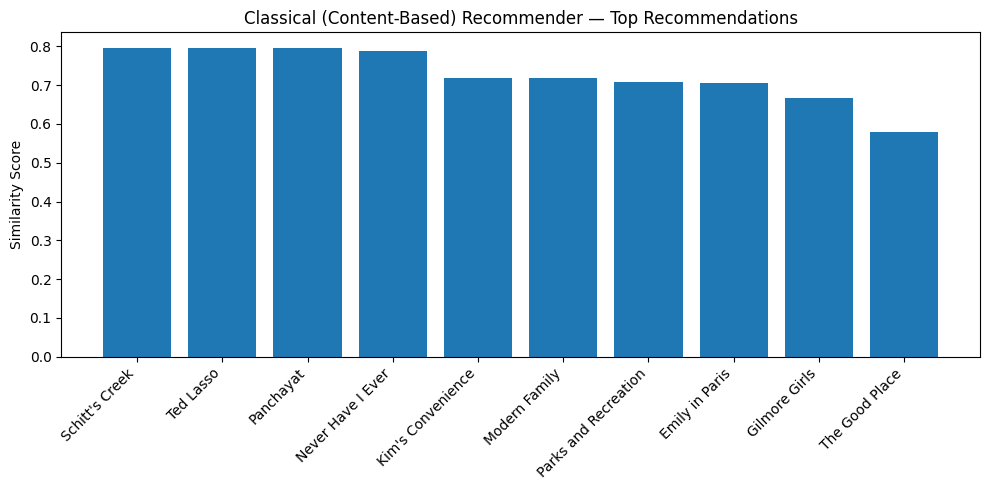

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# ---------- Your ratings (Step 1) ----------
data = [
    ("How I Met Your Mother", 10, "comedy"),
    ("The Summer I Turned Pretty", 10, "love"),
    ("The Office", 10, "fun"),
    ("The Vampire Diaries", 8, "love"),
    ("The Originals", 10, "thrill"),
    ("Wednesday", 7, "thrill"),
    ("Friends", 10, "comedy"),
    ("Brooklyn Nine-Nine", 7, ""),
    ("The Big Bang Theory", 10, "comedy"),
    ("Special Ops", 10, "thrill"),
    ("Happy Family", 10, "comedy"),
    ("Mirzapur", 10, "thrill"),
    ("The Family Man", 9, "fun"),
    ("Upload", 5, "interesting"),
    ("The Peripheral", 6, ""),
    ("Foundation", 4, ""),
    ("Money Heist", 3, ""),
    ("Kurukshetra", 8, "knowledge"),
    ("Shadow and Bone", 2, ""),
    ("Made in Heaven", 1, "controversial"),
]
ratings_df = pd.DataFrame(data, columns=["series","rating","note"])

# ---------- Tag space & assignments ----------
TAGS = ["comedy","feelgood","romance","thriller","action","spy","workplace",
        "fantasy","scifi","heist","dark","controversial","drama","family"]

tag_map = {
    "How I Met Your Mother": ["comedy","feelgood","romance","workplace","family"],
    "The Summer I Turned Pretty": ["romance","feelgood","drama","family"],
    "The Office": ["comedy","workplace","feelgood"],
    "The Vampire Diaries": ["romance","fantasy","drama"],
    "The Originals": ["thriller","fantasy","drama","action"],
    "Wednesday": ["fantasy","drama","comedy"],
    "Friends": ["comedy","feelgood","romance","workplace","family"],
    "Brooklyn Nine-Nine": ["comedy","workplace","action"],
    "The Big Bang Theory": ["comedy","workplace","feelgood"],
    "Special Ops": ["thriller","spy","action","drama"],
    "Happy Family": ["comedy","family","feelgood"],
    "Mirzapur": ["thriller","action","dark","drama"],
    "The Family Man": ["thriller","spy","action","drama"],
    "Upload": ["scifi","comedy","romance"],
    "The Peripheral": ["scifi","thriller","drama"],
    "Foundation": ["scifi","drama"],
    "Money Heist": ["heist","thriller","drama"],
    "Kurukshetra": ["drama","family"],
    "Shadow and Bone": ["fantasy","drama","romance"],
    "Made in Heaven": ["drama","controversial","romance"],
}

def encode(tags):
    v = np.zeros(len(TAGS))
    for t in tags:
        if t in TAGS: v[TAGS.index(t)] = 1.0
    return v

item_vecs = {s: encode(tag_map.get(s, [])) for s in ratings_df["series"]}

# ---------- Build user preference vector ----------
user_vec = np.zeros(len(TAGS))
for _, r in ratings_df.iterrows():
    w = r["rating"] - 5.0  # center around 5
    user_vec += w * item_vecs[r["series"]]
user_vec = user_vec / (np.linalg.norm(user_vec) + 1e-12)

# ---------- Candidate pool (unseen in your original 20) ----------
candidates = [
    "Schitt's Creek","Ted Lasso","Never Have I Ever","Modern Family","Emily in Paris",
    "Parks and Recreation","The Good Place","Kim's Convenience","Panchayat","Jack Ryan",
    "Stranger Things","The Boys","Reacher","Gilmore Girls"
]
cand_tags = {
    "Schitt's Creek": ["comedy","feelgood","family","drama"],
    "Ted Lasso": ["comedy","feelgood","drama","family"],
    "Never Have I Ever": ["comedy","romance","feelgood","family","drama"],
    "Modern Family": ["comedy","family","feelgood"],
    "Emily in Paris": ["romance","comedy","feelgood","drama"],
    "Parks and Recreation": ["comedy","workplace","feelgood"],
    "The Good Place": ["comedy","feelgood","fantasy"],
    "Kim's Convenience": ["comedy","feelgood","family"],
    "Panchayat": ["comedy","drama","feelgood","family"],
    "Jack Ryan": ["thriller","spy","action","drama"],
    "Stranger Things": ["scifi","fantasy","drama","thriller"],
    "The Boys": ["dark","action","drama"],
    "Reacher": ["action","thriller","drama"],
    "Gilmore Girls": ["drama","family","feelgood"],
}
cand_vecs = {c: encode(cand_tags.get(c, [])) for c in candidates}

def cosine(a,b):
    na, nb = np.linalg.norm(a), np.linalg.norm(b)
    return 0.0 if na==0 or nb==0 else float(np.dot(a,b)/(na*nb))

scores = [(c, cosine(user_vec, cand_vecs[c])) for c in candidates]
rec_df = (pd.DataFrame(scores, columns=["candidate_series","score"])
            .sort_values("score", ascending=False)
            .reset_index(drop=True))
print(rec_df)

# ---------- Save chart ----------
topn = 10
top = rec_df.head(topn)
plt.figure(figsize=(10,5))
plt.bar(top["candidate_series"], top["score"])
plt.xticks(rotation=45, ha="right")
plt.title("Classical (Content-Based) Recommender — Top Recommendations")
plt.ylabel("Similarity Score")
plt.tight_layout()
plt.savefig("classical_recs_chart.png")  # attach/screenshot this in your report
